In [397]:
# data was accessed from kaggle at the following link on 3-28-25
# https://www.kaggle.com/datasets/rtatman/188-million-us-wildfires
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.model_selection import KFold, GridSearchCV, train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import mean_squared_error, RocCurveDisplay, auc, roc_curve
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import label_binarize
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
np.set_printoptions(precision=10, suppress=True)


os.chdir("c:/Users/AVILA/OneDrive/Documents/GitHub/Forest-fire-prediction")

df = pd.read_csv("forest_fires.csv", low_memory = False)

### Basic summary information regarding the dataset

> Section contents:

This section contains some brief analysis and preprocessing of the dataset. I create a variety of categorical columns, conduct some initial exploration into the most common causes of fires, and break down the causes of fires by quarter. Additionally I produce a table that contains mean, median, and standard deviation of fire size by state. This table was used for intial exploration and to gain familiarity with the dataset, most of which is not shown in this notebook.

> Notes:

1. The raw data (df) contains data that indicates the day of the year that the fire was identified, but I cannot use that in the algorithm as a numeric value because the algorithm will assume ordinal importance. Instead, I convert the "doy" column (day of the year) to a season indicator of Spring, Summer, Fall, Winter, with an even split of 91 days.

2. Given the summary statistics generated in the file, it was necessary to conduct an anomaly analysis, which is referenced in another file in the repository. However note that the anomaly analysis was not integrated into the decision tree algorithms used in this file. 

In [398]:
fires = pd.DataFrame({"doy": df["DISCOVERY_DOY"],
            "year": df["FIRE_YEAR"],
            "cause_code": df["STAT_CAUSE_CODE"],
            "cause": df["STAT_CAUSE_DESCR"],
            "fire_size": df["FIRE_SIZE"],
            "longitude": df["LONGITUDE"],
            "latitude": df["LATITUDE"],
            "state": df["STATE"]})

fires["season"] = np.where(fires["doy"] < 91, "Q1", "Q2")
fires.loc[(fires["doy"] >=91*2) & (fires["doy"] < 91*3), "season"] = "Q3"
fires.loc[(fires["doy"] >= 91*3), "season"] = "Q4"
fires.head()

,doy,year,cause_code,cause,fire_size,longitude,latitude,state,season
0,33,2005,9.0,Miscellaneous,0.10,-121.005833,40.036944,CA,Q1
1,133,2004,1.0,Lightning,0.25,-120.404444,38.933056,CA,Q2
2,152,2004,5.0,Debris Burning,0.10,-120.735556,38.984167,CA,Q2
3,180,2004,1.0,Lightning,0.10,-119.913333,38.559167,CA,Q2
4,180,2004,1.0,Lightning,0.10,-119.933056,38.559167,CA,Q2


<Axes: xlabel='Count', ylabel='cause'>

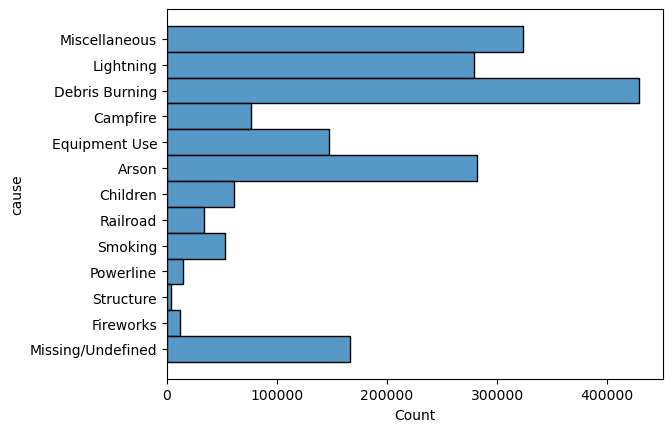

In [399]:
sns.histplot(fires, y = "cause")

In [400]:
pd.DataFrame(fires.groupby(["cause", "season"]).count()).iloc[:, [0]].rename(columns = {"doy": "count"})

count
cause             season        
Arson             Q1       92938
                  Q2       85922
                  Q3       50181
                  Q4       52414
Campfire          Q1       12239
                  Q2       22936
                  Q3       28196
                  Q4       12768
Children          Q1       15126
                  Q2       23955
                  Q3       13887
                  Q4        8199
Debris Burning    Q1      169388
                  Q2      127772
                  Q3       60221
                  Q4       71647
Equipment Use     Q1       27291
                  Q2       46758
                  Q3       50212
                  Q4       23351
Fireworks         Q1         579
                  Q2        3005
                  Q3        7229
                  Q4         687
Lightning         Q1        3621
                  Q2       65032
                  Q3      203404
                  Q4        6411
Miscellaneous     Q1       71646
                  Q2      107065
                  Q3       94423
                  Q4       50671
Missing/Undefined Q1       60582
                  Q2       44371
                  Q3       41271
                  Q4       20499
Powerline         Q1        2687
                  Q2        5317
                  Q3        4446
                  Q4        1998
Railroad          Q1       11005
                  Q2       12692
                  Q3        5659
                  Q4        4099
Smoking           Q1       12632
                  Q2       16540
                  Q3       15178
                  Q4        8519
Structure         Q1         824
                  Q2        1313
                  Q3         902
                  Q4         757

In [401]:
# producing a table of mean and standard deviation
# additional analysis was conducted using this table that is not showed in this file to gain familiarity with the dataset

mean_fire_size_state = pd.DataFrame({"mean": round(fires.groupby("state")["fire_size"].mean(), 0)})
median_fire_size_state = pd.DataFrame({"median": fires.groupby("state")["fire_size"].median()})
std_fire_size_state = pd.DataFrame({"std": round(fires.groupby("state")["fire_size"].std(), 2)})
fire_size_state = mean_fire_size_state.merge(median_fire_size_state, how = "left", on = "state")
fire_size_state = fire_size_state.merge(std_fire_size_state, how = "left", on = "state").reset_index().sort_values(by = "mean", ascending = False)
fire_size_state.head(10)


,state,mean,median,std
0,AK,2510.0,0.2,19600.65
33,NV,532.0,0.1,5888.67
13,ID,373.0,0.2,5643.33
32,NM,170.0,0.3,2858.99
51,WY,170.0,0.5,2195.53
26,MT,154.0,0.2,2864.76
48,WA,143.0,0.2,3120.71
37,OR,138.0,0.1,4225.90
45,UT,134.0,0.1,2648.87
29,NE,121.0,1.0,1848.20


# Fitting Decision Trees and Random Forest Models

The following section is broken into two parts:

1) The dataset contains a column for fire_size as measured in acres. I first fit both a Regression Decision Tree and a Regression Random Forest to predict the size of a fire given relevant features. I then tune over both the max_depth and the min_impurity_decrease parameters for both models. After training both of these models, I then fit a full decision tree and full random forest and prune these models by tuning over ccp_alpha. Finally I compare the error rates across these four models to determine the best predictive capacity. 

2) I convert the fire_size column into a category broken into four parts; small, medium, large, and extremely large fires. I then repeat the above task of fitting a Classification Decision Tree, a Classification Random Forest, and tuning over max_depth, min_impurity_decrease, and ccp_alpha to predict the size of a fire given relevant features. I then compare the error rates across these four models with the Regression task in part 1), at which point we determine which is the best model to utilize for deployment

### Regression Decision Tree, tuning over max_depth + min_impurity_decrease

DecisionTreeRegressor(max_depth=3, min_impurity_decrease=0.47575268405469684)
mean training error in acres: 2004.95
mean test error in acres: 1993.27


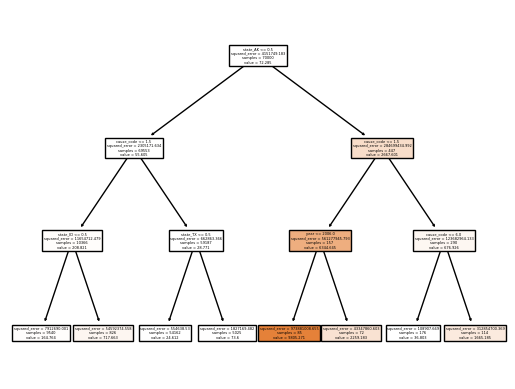

In [402]:
fires_binary_copy = fires.copy()
fires_binary_copy = pd.get_dummies(fires_binary_copy, columns = ["state", "season"])
fires_binary_copy = fires_binary_copy.drop(["doy", "longitude", "latitude", "cause"], axis = 1)

# I am cutting down the size of the dataset due to the excessive time it takes to train the following models. 

fires_binary_copy = fires_binary_copy.sample(n = 100000, random_state = 20)

X_train, X_test, y_train, y_test = train_test_split(fires_binary_copy.loc[:, fires_binary_copy.columns != "fire_size"],
                                                    fires_binary_copy["fire_size"], 
                                                    test_size = .3, 
                                                    shuffle = True,
                                                    random_state = 20)

tree = DecisionTreeRegressor()
impurity_decrease = np.power(np.linspace(.0001, 10, 30), 2)
depth = np.linspace(3, 20, 17).astype(int)
parameters = {"min_impurity_decrease": impurity_decrease,
              "max_depth": depth}
kfcv = KFold()
cvgs = RandomizedSearchCV(tree, parameters, cv = kfcv, n_jobs = -1, n_iter = 50, random_state = 20)

cvgs.fit(X_train, y_train)
print(cvgs.best_estimator_)

#fitting the full decision tree on the training data validate using the test data.
tree = DecisionTreeRegressor(min_impurity_decrease = .475752684, max_depth = 3)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
y_pred_train = tree.predict(X_train)

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred)

print("mean training error in acres:", round(np.sqrt(train_mse), 2))
print("mean test error in acres:", round(np.sqrt(test_mse), 2))

plot_tree(tree, filled = True, feature_names = X_train.columns)
plt.show()

The Decision Tree model as it currently stands is predicting with an average error of 1993.27 acres, which translates to approximately 3.12 square miles. 

### Fitting a full Decision Tree, tuning over ccp_alpha, and pruning

DecisionTreeRegressor(ccp_alpha=3208.194030306935, random_state=20)
mean training error in acres: 1757.91
mean test error in acres: 2108.09


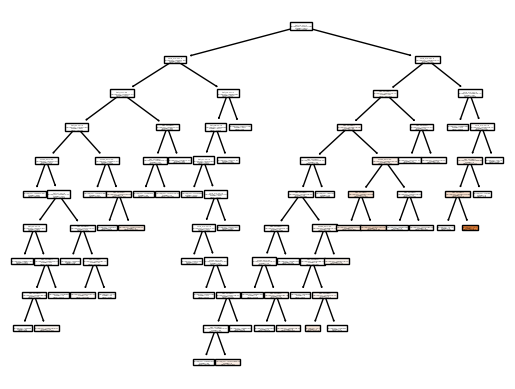

In [403]:
tree = DecisionTreeRegressor(random_state = 20)
tree.fit(X_train, y_train)

ccpp = tree.cost_complexity_pruning_path(X_train, y_train)
parameters = {"ccp_alpha": ccpp.ccp_alphas}

random_search = RandomizedSearchCV(tree, 
                                   parameters, 
                                   cv = kfcv, 
                                   n_iter = 200, 
                                   n_jobs = -1, 
                                   scoring = "neg_mean_squared_error", 
                                   random_state = 20)
random_search.fit(X_train, y_train)

print(random_search.best_estimator_)

tree = DecisionTreeRegressor(ccp_alpha = 3208.19403, random_state = 20)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
y_pred_train = tree.predict(X_train)

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred)

print("mean training error in acres:", round(np.sqrt(train_mse), 2))
print("mean test error in acres:", round(np.sqrt(test_mse), 2))
plot_tree(tree, filled = True, feature_names = X_train.columns)
plt.show()

### Random Forest Regression Model, tuning over max_depth + max_impurity_decrease

In [404]:
random_forest = RandomForestRegressor(n_estimators = 30, 
                                      random_state = 20, 
                                      n_jobs = -1)
kfcv = KFold()
# I use the same paramters as the decision tree model to tune over
parameters_depth_impurity = {"min_impurity_decrease": impurity_decrease,
              "max_depth": depth}
gscv = RandomizedSearchCV(random_forest, parameters_depth_impurity, cv = kfcv, n_jobs = -1, n_iter = 50, random_state = 20)

gscv.fit(X_train, y_train)
print(gscv.best_estimator_)

random_forest = RandomForestRegressor(max_depth = 3, 
                                      min_impurity_decrease = 34.36433769, 
                                      n_estimators = 30)
random_forest.fit(X_train, y_train)
y_pred_train_rf = random_forest.predict(X_train)
y_pred_test_rf = random_forest.predict(X_test)

train_mse_rf = mean_squared_error(y_train, y_pred_train_rf)
test_mse_rf = mean_squared_error(y_test, y_pred_test_rf)

print("mean training error in acres:", round(np.sqrt(train_mse_rf), 2))
print("mean test error in acres:", round(np.sqrt(test_mse_rf), 2))

RandomForestRegressor(max_depth=3, min_impurity_decrease=34.364337694934605,
                      n_estimators=30, n_jobs=-1, random_state=20)
mean training error in acres: 1999.48
mean test error in acres: 1997.2


### Fitting a full Random Forest, tuning over ccp_alpha, and pruning

In [405]:
random_forest = RandomForestRegressor(random_state = 20, n_estimators = 30)
random_forest.fit(X_train, y_train)


#the below captures the cost complexity pruning path for each individual tree withing the random forest.
ccp_alphas = []

print("capturing ccp_alphas")
for tree in random_forest.estimators_:
    path = tree.cost_complexity_pruning_path(X_train, y_train)
    ccp_alphas.extend(path.ccp_alphas)

#we then need to do grid search for each of the ccp_alphas in ccp_alphas
parameters = {"ccp_alpha": ccp_alphas}

print('conducting grid_search')
randomized_search = RandomizedSearchCV(random_forest, 
                                       parameters, 
                                       n_iter = 50, 
                                       n_jobs = -1, 
                                       random_state = 20, 
                                       cv = kfcv)
randomized_search.fit(X_train, y_train)

#if everything works right, we should get the best ccp_alpha for the entirety of the random forest model
print(randomized_search.best_estimator_)

random_forest = RandomForestRegressor(random_state = 20, 
                                      n_estimators = 30, 
                                      ccp_alpha = 33.64500356, 
                                      n_jobs = -1)
random_forest.fit(X_train, y_train)

y_pred_train = random_forest.predict(X_train)
y_pred_test = random_forest.predict(X_test)

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)

print("mean squared error training data, random forest: ", round(np.sqrt(train_mse), 2))
print("mean squared error test data, random forest: ", round(np.sqrt(test_mse), 2))

capturing ccp_alphas
conducting grid_search
RandomForestRegressor(ccp_alpha=33.64500356481623, n_estimators=30,
                      random_state=20)
mean squared error training data, random forest:  1786.72
mean squared error test data, random forest:  2114.43


> Quick Aside

I wanted to quickly see how a linear regression model would perform with the data. Given that all of the features are one-hot coded, I knew that this model risks having low predicitive capabilities and would be extremely unstable via multicollinearity, however as a thought experiment and as a potential baseline, I wanted to see if it OLS could serve to be a comparable alternative.

Below is an estimate of a Linear Regression, which we see performs exceptionally poorly (to be expected). 

In [406]:
# for this data we go back to the full fires dataset.
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# If I want to run this as a linear regression, I have to adjust the fires_binary_copy to include dummy variables for both the year and cause_code columns

fbc_expanded = pd.get_dummies(fires_binary_copy, columns = ["year"])
fbc_expanded = pd.get_dummies(fbc_expanded, columns = ["cause_code"])
labels = fbc_expanded.loc[:, "fire_size"]
features = fbc_expanded.drop("fire_size", axis = 1)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = .3, random_state = 20, shuffle = True)

ols = LinearRegression()
ols.fit(X_train, y_train)
y_pred = ols.predict(X_test)

print(ols.score(X_train, y_train))
print(ols.score(X_test, y_test))


0.013570273357808471
0.005266546017926421


> Continuing our Analysis...

What if we broke the "fire size" feature into categories? In other words, instead of predicting a continuous value, we could predict small through extra large, where each category contains a range of values?

Using the data, lets create some definitions for our distinction between small, medium, large, and extra large fires:

### Preparing data for our classification models

In [407]:
#separating the continuous values into 4 distinct classes
print("number of fires less than one acre: ", fires[fires["fire_size"] < 1].shape[0])
print("number of fires between one acre and 320 acres (half a square mile): ", (fires[(fires["fire_size"] >= 1) & (fires["fire_size"] < 320)]).shape[0])
print("number of fires between 320 acres and 640 acres (full square mile): ", (fires[(fires["fire_size"] >= 320) & (fires["fire_size"] < 640)]).shape[0])
print("number of fires greater than 640 acres: ", fires[fires["fire_size"] > 640].shape[0])

#creating a new column to capture the classifications
fbc_expanded["fire_size_cat"] = np.where(fbc_expanded["fire_size"] < 1, "small", "medium")
fbc_expanded.loc[(fires["fire_size"] >= 320) & (fbc_expanded["fire_size"] < 640), "fire_size_cat"] = "large"
fbc_expanded.loc[fbc_expanded["fire_size"] > 640, "fire_size_cat"] = "extremely large"

number of fires less than one acre:  912076
number of fires between one acre and 320 acres (half a square mile):  944663
number of fires between 320 acres and 640 acres (full square mile):  8631
number of fires greater than 640 acres:  14922


The above statistics indicate that nearly all of the fires that occur in the United States are from small to medium sized fires. But the fires that have the greatest impact are the fires that exceed one 640 acres. Therefore there is a significant interest in being able to accurately predict large and extremely large fires. 

Now lets run the decision trees again using the categories, instead of the numeric acerage.

### Classification Decision Tree and Random Forest, tuning over max_depth + max_impurity_decrease

DecisionTreeClassifier(max_depth=14, min_impurity_decrease=1e-08)
RandomForestClassifier(max_depth=18, min_impurity_decrease=1e-08,
                       n_estimators=30, random_state=20)


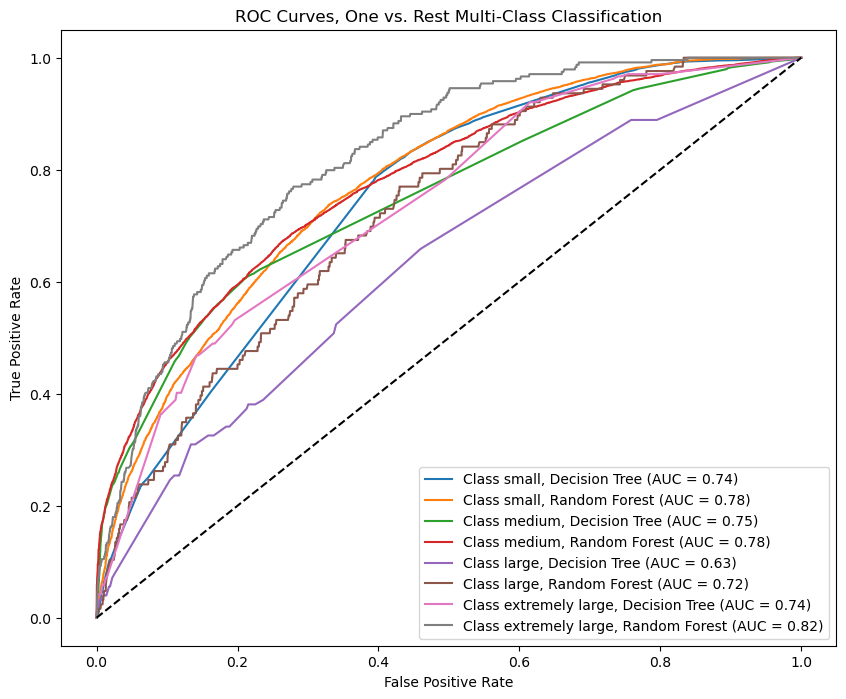

In [408]:
tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier(n_estimators = 30, random_state = 20)

labels = fbc_expanded.loc[:, "fire_size_cat"]
labels = label_binarize(labels, classes = ["small", "medium", "large", "extremely large"])
features = fbc_expanded.drop(["fire_size", "fire_size_cat"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = .3, random_state = 20, shuffle = True)

randomized_search_tree = RandomizedSearchCV(tree, 
                                            parameters_depth_impurity, 
                                            cv = kfcv, 
                                            n_iter = 50, 
                                            n_jobs = -1, 
                                            random_state = 20)
randomized_search_tree.fit(X_train, y_train)
print(randomized_search_tree.best_estimator_)

randomized_search_random_forest = RandomizedSearchCV(random_forest, 
                                                     parameters_depth_impurity, 
                                                     cv = kfcv, 
                                                     n_iter = 50, 
                                                     n_jobs = -1, 
                                                     random_state = 20)
randomized_search_random_forest.fit(X_train, y_train)
print(randomized_search_random_forest.best_estimator_)

#fitting optimized decision tree and random forest classification models
#note that the min_impurity_decrease is so small from the previous cell that it is not really worth integrating into these models.
tree = DecisionTreeClassifier(max_depth = 14)

random_forest = RandomForestClassifier(max_depth = 18, 
                                       n_estimators = 30, 
                                       random_state = 20)

tree.fit(X_train, y_train)
tree_predict_proba = np.array(tree.predict_proba(X_test))

random_forest.fit(X_train, y_train)
random_forest_predict_proba = np.array(random_forest.predict_proba(X_test))

#visualizing the ROC Curves for each class, for both decision tree and random forest
fig, ax = plt.subplots(figsize=(10, 8))

# since we are displaying a multiclass one-vs-rest roc curve, we need to iterate through each binarized class in y_test 
class_names = ["small", "medium", "large", "extremely large"]
for i in range(y_test.shape[1]):
    tree_roc_display = RocCurveDisplay.from_predictions(y_test[:,i],
                                                        tree_predict_proba[i][:, 1],
                                                        name = f"Class {class_names[i]}, Decision Tree",
                                                        ax = ax)
    random_forest_roc_display = RocCurveDisplay.from_predictions(y_test[:, i],
                                                                 random_forest_predict_proba[i][:, 1],
                                                                 name = f"Class {class_names[i]}, Random Forest",
                                                                 ax = ax)
  

plt.plot([0,1], [0,1], color = "black", linestyle = "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves, One vs. Rest Multi-Class Classification")
plt.legend(loc = "lower right")
plt.show()


### Classification Decision Tree and Random Forest, tuning over ccp_alpha

DecisionTreeClassifier(ccp_alpha=6.973850801340518e-05)
conducting grid_search
RandomForestClassifier(ccp_alpha=6.06088372109737e-05, n_estimators=50,
                       random_state=20)


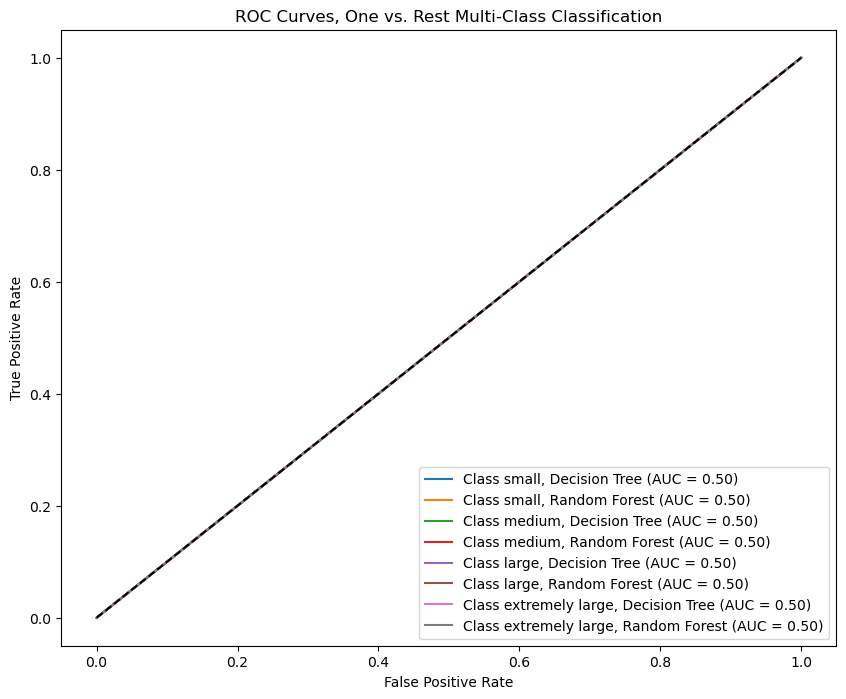

In [409]:
tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier(n_estimators = 50, random_state = 20)

#the below captures the cost complexity pruning path for each individual tree withing the random forest.

# TREE
path_tree = tree.cost_complexity_pruning_path(X_train, y_train)
parameters_tree = {"ccp_alpha": path_tree.ccp_alphas}

randomized_search_tree = RandomizedSearchCV(tree,
                                            parameters_tree,
                                            n_jobs = -1,
                                            n_iter = 50,
                                            cv = kfcv,
                                            random_state = 20)

randomized_search_tree.fit(X_train, y_train)

print(randomized_search_tree.best_estimator_)

# RANDOM FOREST
random_forest.fit(X_train, y_train)
ccp_alphas_forest = []

for rf_tree in random_forest.estimators_:
    path_random_forest = rf_tree.cost_complexity_pruning_path(X_train, y_train)
    ccp_alphas_forest.extend(path_random_forest.ccp_alphas)

#we then need to do grid search for each of the ccp_alphas in ccp_alphas
parameters_rf = {"ccp_alpha": ccp_alphas_forest}

print('conducting grid_search')
randomized_search_rf = RandomizedSearchCV(random_forest, 
                                       parameters_rf, 
                                       n_iter = 50, 
                                       n_jobs = -1, 
                                       random_state = 20, 
                                       cv = kfcv)
randomized_search_rf.fit(X_train, y_train)

#if everything works right, we should get the best ccp_alpha for the entirety of the random forest model
print(randomized_search_rf.best_estimator_)

# now creating the ROC curve visualizations similar to above.
class_weights = [{0: 1, 1: 1},
                 {0: 1, 1: 1},
                 {0: 800, 1: 900},
                 {0: 700, 1: 900}]
tree = DecisionTreeClassifier(ccp_alpha = 6.735633751)
random_forest = RandomForestClassifier(ccp_alpha = 6.060883721, n_estimators = 50, random_state = 20, class_weight = class_weights)

tree.fit(X_train, y_train)
tree_predict_proba = tree.predict_proba(X_train)

random_forest.fit(X_train, y_train)
random_forest_predict_proba = random_forest.predict_proba(X_train)


fig, ax = plt.subplots(figsize = [10, 8])

for i in range(y_test.shape[1]):
    tree_roc_display = RocCurveDisplay.from_predictions(y_train[:,i],
                                                        tree_predict_proba[i][:, 1],
                                                        name = f"Class {class_names[i]}, Decision Tree",
                                                        ax = ax)
    random_forest_roc_display = RocCurveDisplay.from_predictions(y_train[:, i],
                                                                 random_forest_predict_proba[i][:,1],
                                                                 name = f"Class {class_names[i]}, Random Forest",
                                                                 ax = ax)
  

plt.plot([0,1], [0,1], color = "black", linestyle = "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves, One vs. Rest Multi-Class Classification")
plt.legend(loc = "lower right")
plt.show()


In [410]:
pd.DataFrame(random_forest.predict(X_train)).value_counts()

0  1  2  3
0  1  0  0    70000
Name: count, dtype: int64

Unfortunately, this random_forest ccp_alpha model is not performing better than a coin flip.

The problem that we are running to is that the Random Forest model tuned with ccp_alpha is predicting "medium" for all labels. This behavior in the model is a result of the significant class imbalances that we see with large and extremely large fires relative to small and medium; >90% of the samples are labeled as either small or medium sized fires, therefore it is extremely difficult for the model to recognize patterns of large and extremely large fires. Because the model is having difficulty determining large and extremely large fires, it is defaulting to predicting the most frequent class, which is medium fires.

If I want to alleviate the problem, I would need to use StratifiedKFold cross validation, which would maintain the same percentage of large and extremely large fires in the sample. However I run into an issue in plotting the ROC curves in a one-vs-rest manner, which would make comparison between this model and the previous model difficult. Therefore I opt to drop these models that tune over the ccp_alpha hyperparamter.